# Seismic Energy

In [1]:
import numpy as np
from numpy import array as arr, asarray, nan
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import seaborn as sbn
from pathlib import Path
import asdf
import scipy.signal as sig
from scipy.optimize import curve_fit
import obspy
%matplotlib inline

from materialproperties.explosive import pentex

In [2]:
EBLAST = pentex.spec_en * .09

In [3]:
plt.matplotlib.rc("font", size=15)
plt.matplotlib.rc("figure", figsize=(12, 7.5))

In [4]:
pltt = sbn.color_palette(['#2271B2', '#D55E00', '#359B73', '#E20134',
                          '#A40122', '#000000'])
sbn.set_palette(pltt)
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0)]

In [5]:
import datarepo

msumm = datarepo.get_byu_mics_summ()
pos = datarepo.get_pos()
pos.head()

label  h_off       r         ϕ        θ   x_raw   y_raw  z_raw  \
point                                                                         
5           ref1-1  0.000  26.091  266.0937  87.4541  -1.776  26.005  1.159   
6      pad1, pipe1  1.915  36.530   23.5036  91.5113  33.488 -14.563 -0.963   
7      pad1, pipe2  1.935  36.394   24.4506  91.5016  33.119 -15.059 -0.954   
8      pad1, pipe3  1.925  36.246   25.4001  91.4915  32.731 -15.542 -0.943   
9      pad2, pipe1  1.935  35.895   29.1611  91.4908  31.335 -17.485 -0.934   

            x       y      z        latn_m         lone_m        ht  \
point                                                                 
5      -0.000   0.000  2.764  4.708123e+06  695981.584000  407.4255   
6      15.481  51.474 -1.273  4.708175e+06  695969.604324  403.3885   
7      16.096  51.427 -1.284  4.708176e+06  695970.162203  403.3775   
8      16.712  51.357 -1.263  4.708176e+06  695970.732317  403.3985   
9      19.100  51.213 -1.264  4.708177e+06  695972.879494  403.3975   

        latn_deg   lone_deg  
point                        
5      42.500659 -78.614849  
6      42.501134 -78.614977  
7      42.501136 -78.614970  
8      42.501138 -78.614963  
9      42.501147 -78.614937

In [6]:
xyz = datarepo.xyz
lxyz = datarepo.lxyz

In [7]:
ucsb = asdf.open('../data/UCSB_seis_inf/asdf/seis_inf.asdf', mode='rw')
ucsb.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.7.1
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─comment (dict)
│ └─anl/ucsb_seis_inf_to_asdf.ipynb (dict) ...
├─pad1 (dict)
│ ├─ascii_off (float): 1.8025
│ ├─inf (dict) ...
│ ├─seis (dict) ...
│ └─t (Reference)
├─pad2 (dict)
│ ├─ascii_off (float): 3.425
│ ├─inf (dict) ...
│ ├─seis (dict) ...
│ └─t (Reference)
├─pad3 (dict) ...
└─pad4 (dict) ...
Some nodes not shown.


In [8]:
mtu = asdf.open('../data/MTU_seis_infr/asdf/mtu_seis_inf.asdf', mode='rw')
mtu.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.1
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata)
│     ├─extension_class (str): asdf.extension.BuiltinExtension
│     └─software (Software) ...
└─gp (dict)
  └─first_arr (dict)
    ├─'r': First arrival distances.pad1 (dict)
    ├─note (str): 'tblast': Estimated time of blast on the 'local' time line.
'Delta_tc': Ti (truncated)
    ├─pad1 (dict)
    │ ├─Delta_tc (NDArrayType): shape=(2,), dtype=float64
    │ ├─idx (list) ...
    │ ├─r (NDArrayType): shape=(23,), dtype=float64
    │ └─4 not shown
    ├─pad2 (dict) ...
    ├─pad3 (dict) ...
    └─pad4 (dict) ...
Some nodes not shown.


In [9]:
fa = mtu['gp']['first_arr']  # first arribal data from geophones

## Imported Data

### Sound Speeds

From BYU microphones (`mics_c.ipynb`).

In [10]:
cs = {i: msumm.loc[msumm['pad'] == i, 'c'].iloc[0] for i in (1, 2, 3, 4)}

### Crater Coordinates

In [11]:
posmap = {1: [6, 7, 8], 2: [10, 11, 12], 3: [13, 14, 15], 4: [17, 18, 19]}
pap = posmap[1] + posmap[2] + posmap[3] + posmap[4]
pap

[6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19]

In [12]:
pos.loc[pap, lxyz]

label       x       y      z
point                                     
6       pad1, pipe1  15.481  51.474 -1.273
7       pad1, pipe2  16.096  51.427 -1.284
8       pad1, pipe3  16.712  51.357 -1.263
10      pad2, pipe2  19.718  51.157 -1.245
11      pad2, pipe3  20.349  51.083 -1.242
12     pad2, pipe1a  22.894  50.031 -1.275
13      pad3, pipe1  22.874  50.027 -1.265
14      pad3, pipe2  23.183  50.533 -1.270
15      pad3, pipe3  23.493  50.002 -1.265
17      pad4, pipe2  26.317  50.168 -1.283
18      pad4, pipe3  26.581  49.628 -1.254
19     pad1, balls1  15.240  51.485 -1.433

In [13]:
padcenter = pos.loc[[13, 15], xyz].sum(axis=0) / 2
padcenter

x    23.1835
y    50.0145
z    -1.2650
dtype: float64

In [14]:
cratercoords = {i: pos.loc[posmap[i], xyz] for i in (1, 2, 3, 4)}
cratercoords

{1:             x       y      z
 point                       
 6      15.481  51.474 -1.273
 7      16.096  51.427 -1.284
 8      16.712  51.357 -1.263,
 2:             x       y      z
 point                       
 10     19.718  51.157 -1.245
 11     20.349  51.083 -1.242
 12     22.894  50.031 -1.275,
 3:             x       y      z
 point                       
 13     22.874  50.027 -1.265
 14     23.183  50.533 -1.270
 15     23.493  50.002 -1.265,
 4:             x       y      z
 point                       
 17     26.317  50.168 -1.283
 18     26.581  49.628 -1.254
 19     15.240  51.485 -1.433}

Infrasound and seismic channels, locations

In [15]:
pos.loc[pos.label.str.contains('NYI'), lxyz]

label          x           y       z
point                                      
129    NYI11  44.257375   57.090228 -1.4825
130    NYI12  28.608807   27.665186 -0.7798
131    NYI13  -7.680367   46.964317 -7.2449
132    NYI21  24.301585  -32.956018 -3.0374
133    NYI22  25.210863  -83.768950 -1.7690
134    NYI23  26.120449 -134.581957  2.8392
135    NYI31  19.772250 -181.535218  2.1016
136    NYI32  20.682395 -232.348372  0.5769
137    NYI33  26.808858 -273.353153 -1.7344

In [16]:
pos.loc[pos.label.str.contains('NYS'), lxyz]

label          x           y       z
point                                      
122    NYS01  28.608807   27.665186 -0.7798
123    NYS02  24.301585  -32.956018 -3.0374
124    NYS03  25.210863  -83.768950 -1.7690
125    NYS04  26.120449 -134.581957  2.8392
126    NYS05  19.772250 -181.535218  2.1016
127    NYS06  20.682395 -232.348372  0.5769
128    NYS07  26.808858 -273.353153 -1.7344

In [17]:
pos.loc[pos.label == 'broadbands', lxyz]

label          x          y    z
point                                       
162    broadbands  49.316993  37.182772 -1.5

In [18]:
cratercoords

{1:             x       y      z
 point                       
 6      15.481  51.474 -1.273
 7      16.096  51.427 -1.284
 8      16.712  51.357 -1.263,
 2:             x       y      z
 point                       
 10     19.718  51.157 -1.245
 11     20.349  51.083 -1.242
 12     22.894  50.031 -1.275,
 3:             x       y      z
 point                       
 13     22.874  50.027 -1.265
 14     23.183  50.533 -1.270
 15     23.493  50.002 -1.265,
 4:             x       y      z
 point                       
 17     26.317  50.168 -1.283
 18     26.581  49.628 -1.254
 19     15.240  51.485 -1.433}

In [19]:
cratercoords[1].sum() / 3

x    16.096333
y    51.419333
z    -1.273333
dtype: float64

In [20]:
pos.loc[pos.label == 'NYS01', xyz]

x          y       z
point                              
122    28.608807  27.665186 -0.7798

In [21]:
dist = {}
for pad in (1, 2, 3, 4):
    co = cratercoords[pad]
    el = {}
    for i in range(1, 8):
        cntr = co.sum() / 3
        el[i] = np.sqrt(np.sum(
            (pos.loc[pos.label == f"NYS0{i}", xyz].values[0] - cntr) ** 2))
    el['xmbm'] = np.sqrt(np.sum(
        (pos.loc[pos.label == 'broadbands', xyz].values[0] - cntr) ** 2))
    el['xmbd'] = el['xmbm']
    dist[f'pad{pad}'] = el
dist

{'pad1': {1: 26.852655606554741,
  2: 84.79173355205576,
  3: 135.49609734855588,
  4: 186.31660087758621,
  5: 233.00799435232838,
  6: 283.81079245158338,
  7: 324.94944039172429,
  'xmbm': 36.143370817014535,
  'xmbd': 36.143370817014535},
 'pad2': {1: 24.321774258879273,
  2: 83.797592146330871,
  3: 134.5932300672001,
  4: 185.45521155957039,
  5: 232.31962922253251,
  6: 283.11145619413026,
  7: 324.16279283659611,
  'xmbm': 31.415102388759664,
  'xmbd': 31.415102388759664},
 'pad3': {1: 23.171533054699974,
  2: 83.16972364081775,
  3: 133.97256873676304,
  4: 184.83824108158149,
  5: 231.77213253005777,
  6: 282.5527883629108,
  7: 323.56113745109036,
  'xmbm': 29.191457694104695,
  'xmbd': 29.191457694104695},
 'pad4': {1: 23.519355779691661,
  2: 83.415768613711947,
  3: 134.21994156627738,
  4: 185.08715179887767,
  5: 232.0061350673559,
  6: 282.7890448596138,
  7: 323.8063239098928,
  'xmbm': 29.719201544429403,
  'xmbd': 29.719201544429403}}

### Metadata for MTU 'Raw'

In [22]:
inv = obspy.read_inventory(
    '../data/MTU_seis_infr/compact/X6.18.bbtrench.20182421030.xml')
inv.get_contents()

{'networks': ['X6'],
 'stations': ['X6.XMBD (Springville, NY, USA)',
  'X6.XMBI (Springville, NY, USA)',
  'X6.XMBM (Springville, NY, USA)',
  'X6.XMBS (Springville, NY, USA)'],
 'channels': ['X6.XMBD..HH1',
  'X6.XMBD..HH2',
  'X6.XMBD..HHZ',
  'X6.XMBD..LOG',
  'X6.XMBI..HDF',
  'X6.XMBI..LOG',
  'X6.XMBM..HH1',
  'X6.XMBM..HH2',
  'X6.XMBM..HHZ',
  'X6.XMBM..LOG',
  'X6.XMBS..HH1',
  'X6.XMBS..HH2',
  'X6.XMBS..HHZ',
  'X6.XMBS..LOG']}

## New Data

In [23]:
infmap = {1: (1, 2), 2: (2, 1), 3: (2, 2), 4: (2, 3), 5: (3, 1), 6: (3, 2), 7: (3, 3)}

### `intvsq`: Integrated square ground velocity.  

Total (`tot`) and per-blast values (`1, ... ,6`). Per-blast values are only possible for the closer channels (`1, 3, xmbm, xmbd`), because the wave components disperse.

*Structure:*
```
pad:
    tot: {1: {}, ..., 7:{}, xmbm: {}, xmbd: {}},
    1: {1: {}, 3:{}, xmbm: {}, xmbd: {}},
    ...,
    6: {1: {}, 3:{}, xmbm: {}, xmbd: {}}
```

In [24]:
intvsq = {
    pad: {'tot': {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}
    for pad in ('pad1', 'pad2', 'pad3', 'pad4')
}
intvsq

{'pad1': {'tot': {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}},
 'pad2': {'tot': {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}},
 'pad3': {'tot': {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}},
 'pad4': {'tot': {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}}

## Helper Functions

### `highpass()`

In [25]:
SRATE_U = 400
SRATE_M = 500

def highpass(data, srate: float, freq: float = 1., half_ord: int = 2):
    freq = freq / (.5 * srate)
    b, a = sig.butter(half_ord, freq, btype='highpass', analog=False, output='ba')
    return sig.filtfilt(b, a, data)

### `infseis_plot()`

Plot infrasound signal, ground velocity components and squared seismics for a station.

In [26]:
def infseis_plot(inf, seis, t, tshot: float = None, filt: bool = False):
    fig, axs = plt.subplots(nrows=5, sharex=True)
    y, ax = inf[:], axs[0]
    if filt:
        y = highpass(inf[:], freq=1.0, half_ord=1)
    ax.plot(t, y)
    ax.set_ylabel(r'$p_\text{inf}\ /\ \mathrm{Pa}$')
    sq = np.zeros_like(t)
    comps = ['hhn', 'hhe', 'hhz'] if 'hhn' in seis.keys() else ['hh1', 'hh2', 'hhz']
    for ax, comp, lbl in zip(axs[1:-1], comps, ['radial', 'tang.', 'z']):
        y = seis[comp][:]
        if filt:
            y = sig.detrend(y, type='linear', overwrite_data=True)
        ax.plot(t, y)
        ax.axhline(y=0, color='gray', lw=.5)
        sq += y ** 2
        if tshot is not None:
            ax.axvline(x=tshot, color='red')
        ax.set_ylabel(r"$\text{%s}\ /\ \mathrm{ms^{-1}}$" % lbl)
    ax = axs[-1]
    ax.plot(t, sq)
    ax.set_ylabel(r'$v^2\ /\ \mathrm{ms^{-1}}$')
    ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
    fig.subplots_adjust(hspace=0.)
    fig.align_ylabels()
    return fig, axs

In [27]:
def linear(x, a, b):
    return a * x + b

### `ri()`

Time dependent distance of first arrival.

In [28]:
def ri(t, v, tc, rc):
    return v * (t - tc) + rc

### `get_sten()`

In [29]:
def get_sten(t, tstart, tend) -> tuple:
    return np.where(t >= tstart)[0][0], np.where(t <= tend)[0][-1]

### `vsq()`

In [30]:
def vsq(vs, t, tstart: float = None, tend: float = None,
        ret_index: bool = False):
    st, en = get_sten(t, tstart, tend) if tstart is not None else (0, len(vs['hhe']))
    ret = np.sum(
        asarray([vs[comp][st:en] ** 2 for comp in vs.keys()]), axis=0)
    return ret, st, en if ret_index else ret

### `integrate()`

In [31]:
def integrate(arg, t, tstart: float = None, tend: float = None,
              ret_index: bool = False) -> float:
    st, en = get_sten(t, tstart, tend) if tstart is not None else (0, len(arg))
    ret = np.trapz(arg[st:en], x=t[st:en])
    return ret, st, en if ret_index else ret

### `integrate_vsq()`

In [32]:
def integrate_vsq(vs, t, tstart, tend) -> float:
    vsquare, st, en = vsq(vs, t, tstart, tend, True)
    return np.trapz(vsquare, x=t[st:en])

### `r_plot()`

Plot $r-t$ lines of seismic signals

In [33]:
def r_plot(seisch, t, rs, xlim, ylim, filt: bool = False):
    amp = 100
    fig, ax = plt.subplots()
    for i in (1, 3, 4, 5, 6, 7):
        seis = seisch[i]
        r, y = rs[i], seis['hhz']
        yn = y / np.max(np.abs(y))
        if filt:
            sig.detrend(yn, type='constant', overwrite_data=True)
        ax.plot(t, r + (20 + (i - 1) * amp) * yn, color='k')
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
    ax.set_ylabel(r'$r\ /\ \mathrm{m}$')
    return fig, ax

## Pad 1

In [34]:
dist

{'pad1': {1: 26.852655606554741,
  2: 84.79173355205576,
  3: 135.49609734855588,
  4: 186.31660087758621,
  5: 233.00799435232838,
  6: 283.81079245158338,
  7: 324.94944039172429,
  'xmbm': 36.143370817014535,
  'xmbd': 36.143370817014535},
 'pad2': {1: 24.321774258879273,
  2: 83.797592146330871,
  3: 134.5932300672001,
  4: 185.45521155957039,
  5: 232.31962922253251,
  6: 283.11145619413026,
  7: 324.16279283659611,
  'xmbm': 31.415102388759664,
  'xmbd': 31.415102388759664},
 'pad3': {1: 23.171533054699974,
  2: 83.16972364081775,
  3: 133.97256873676304,
  4: 184.83824108158149,
  5: 231.77213253005777,
  6: 282.5527883629108,
  7: 323.56113745109036,
  'xmbm': 29.191457694104695,
  'xmbd': 29.191457694104695},
 'pad4': {1: 23.519355779691661,
  2: 83.415768613711947,
  3: 134.21994156627738,
  4: 185.08715179887767,
  5: 232.0061350673559,
  6: 282.7890448596138,
  7: 323.8063239098928,
  'xmbm': 29.719201544429403,
  'xmbd': 29.719201544429403}}

In [35]:
dst = dist['pad1']
dst.pop(2)

84.79173355205576

### Organize and Filter Data

In [36]:
pad = 'pad1'
t_u = ucsb[pad]['t'][:]

infsig = {}
for k, (k1, k2) in infmap.items():
    infsig[k] = highpass(ucsb['pad1']['inf'][k1][k2],
                         SRATE_U, freq=1., half_ord=1)

seissig = {}
for k, v in ucsb['pad1']['seis'].items():
    seissig[k] = {}
    for comp, vv in v.items():
        seissig[k][comp] = highpass(vv, SRATE_U, freq=1 / 10, half_ord=1)

Estimate of shot time from infrasound signal. Speed of sound comes from acoustic microphones (`mics_c.ipynb`).

In [37]:
tas = 3.5533
tshot1 = tas - dst[7] / cs[1]
tshot1

2.6011798153641186

In [38]:
pickt = 2.6591
tblast1 = pickt - dst[1] / cs[1]
tblast1

2.5804202048193838

### Energy

#### Total time interval

In [39]:
sstations = (1, 3, 4, 5, 6, 7)

In [40]:
tst, ten = tblast1, tblast1 + 7.5
for station in sstations:
    seis = seissig[station]
    ivsq = integrate_vsq(seis, t_u, tst, ten)
    intvsq['pad1']['tot'][station] = ivsq
    print(f"{station}: tst={tst:.2f} s, ten={ten:.2f} s, int(vsq)={ivsq:.3e} m^2/s")

1: tst=2.58 s, ten=10.08 s, int(vsq)=1.815e-07 m^2/s
3: tst=2.58 s, ten=10.08 s, int(vsq)=4.435e-09 m^2/s
4: tst=2.58 s, ten=10.08 s, int(vsq)=3.200e-09 m^2/s
5: tst=2.58 s, ten=10.08 s, int(vsq)=2.600e-09 m^2/s
6: tst=2.58 s, ten=10.08 s, int(vsq)=7.350e-10 m^2/s
7: tst=2.58 s, ten=10.08 s, int(vsq)=4.187e-10 m^2/s


Skip station \#2, since z-component broken

#### Per-Blast intervals (for stations \#1, 3)

In [41]:
inter = arr([0., .5, 1., 1.5, 2., 2.5, 3.])
intvs = {1: tblast1 + inter, 3: tblast1 + 0.4 + inter,}
intvs

{1: array([ 2.5804202,  3.0804202,  3.5804202,  4.0804202,  4.5804202,
         5.0804202,  5.5804202]),
 3: array([ 2.9804202,  3.4804202,  3.9804202,  4.4804202,  4.9804202,
         5.4804202,  5.9804202])}

In [42]:
for i in (1, 3):
    for blast, (tst, ten) in enumerate(zip(intvs[i][:-1], intvs[i][1:]), start=1):
        intvsq['pad1'][blast][i] = integrate_vsq(seissig[i], t_u, tst, ten)

(2.0, 7.0)

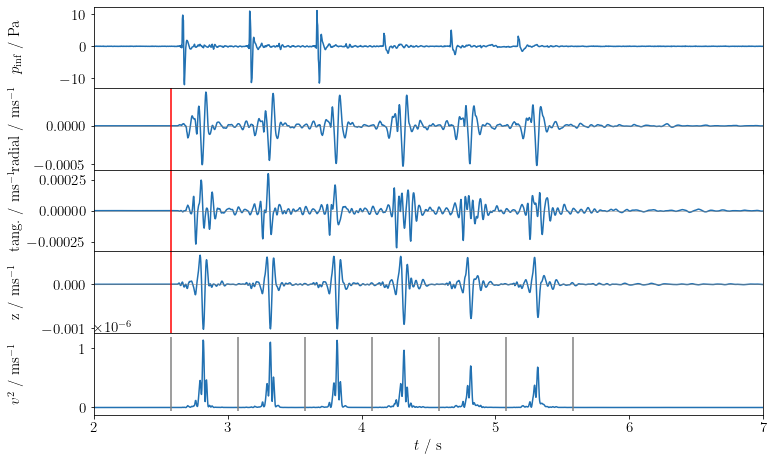

In [43]:
fig, axs = infseis_plot(infsig[1], seissig[1], t_u, tblast1)
ax = axs[-1]
ax.vlines(intvs[1], *ax.get_ylim(), colors='gray')
ax.set_xlim(2, 7)
# fig

(2.0, 7.0)

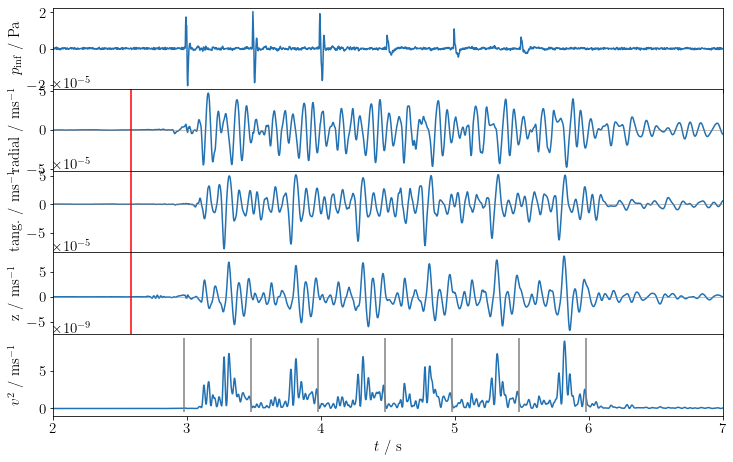

In [44]:
fig, axs = infseis_plot(infsig[3], seissig[3], t_u, tblast1)
ax = axs[-1]
ax.vlines(intvs[3], *ax.get_ylim(), colors='gray')
ax.set_xlim(2, 7)
# fig

In [45]:
intvsq['pad1']

{'tot': {1: 1.8152939637472003e-07,
  3: 4.4347093766472294e-09,
  4: 3.1996488402766493e-09,
  5: 2.6000612980567226e-09,
  6: 7.3504431032794583e-10,
  7: 4.1872020085156253e-10},
 1: {1: 3.4855605626544515e-08, 3: 7.6952993000139031e-10},
 2: {1: 3.3404384392530032e-08, 3: 6.496302538695404e-10},
 3: {1: 3.30200448007441e-08, 3: 6.8960792598900942e-10},
 4: {1: 3.229703068299395e-08, 3: 6.8663625273648827e-10},
 5: {1: 2.3532312217544698e-08, 3: 6.8304716916611379e-10},
 6: {1: 2.4077632136469972e-08, 3: 7.3926846675811259e-10}}

In [46]:
intvsq['pad1']['r'] = dst

## Pad 2

In [47]:
plt.close('all')

In [48]:
dst = dist['pad2']
dst.pop(2)

83.797592146330871

### Organize and Filter Data

In [49]:
pad = 'pad2'
t_u = ucsb[pad]['t'][:]

infsig = {}
for k, (k1, k2) in infmap.items():
    infsig[k] = highpass(ucsb['pad2']['inf'][k1][k2], SRATE_U, freq=1., half_ord=1)

seissig = {}
for k, v in ucsb['pad2']['seis'].items():
    seissig[k] = {}
    for comp, vv in v.items():
        seissig[k][comp] = highpass(vv, SRATE_U, freq=1 / 10, half_ord=1)

Estimate of shot time from infrasound signal. Speed of sound comes from acoustic microphones (`mics_c.ipynb`).

In [50]:
tas = 5.1852
tshot2 = tas - dst[7] / cs[2]
tshot2

4.2455448099925608

In [51]:
pickt = 4.3152
tblast2 = pickt - dst[1] / cs[2]
tblast2

4.2446981351420376

### Energy

#### Total time interval

In [52]:
tst, ten = tblast2, tblast2 + 7.5
for station in sstations:
    seis = seissig[station]
    ivsq = integrate_vsq(seis, t_u, tst, ten)
    intvsq['pad2']['tot'][station] = ivsq
    print(f"{station}: tst={tst:.2f} s, ten={ten:.2f} s, int(vsq)={ivsq:.3e} m^2/s")

1: tst=4.24 s, ten=11.74 s, int(vsq)=1.511e-07 m^2/s
3: tst=4.24 s, ten=11.74 s, int(vsq)=2.711e-09 m^2/s
4: tst=4.24 s, ten=11.74 s, int(vsq)=1.655e-09 m^2/s
5: tst=4.24 s, ten=11.74 s, int(vsq)=1.732e-09 m^2/s
6: tst=4.24 s, ten=11.74 s, int(vsq)=4.428e-10 m^2/s
7: tst=4.24 s, ten=11.74 s, int(vsq)=2.622e-10 m^2/s


Skip station \#2, since z-component broken

#### Per-Blast intervals (for stations \#1, 3)

In [53]:
inter = arr([0., .5, 1., 1.5, 2., 2.5, 3.])
intvs = {1: tblast2 + .085 + inter, 3: tblast2 + 0.4 + inter,}
intvs

{1: array([ 4.32969814,  4.82969814,  5.32969814,  5.82969814,  6.32969814,
         6.82969814,  7.32969814]),
 3: array([ 4.64469814,  5.14469814,  5.64469814,  6.14469814,  6.64469814,
         7.14469814,  7.64469814])}

In [54]:
for i in (1, 3):
    for blast, (tst, ten) in enumerate(zip(intvs[i][:-1], intvs[i][1:]), start=1):
        intvsq['pad2'][blast][i] = integrate_vsq(seissig[i], t_u, tst, ten)

(4.0, 8.0)

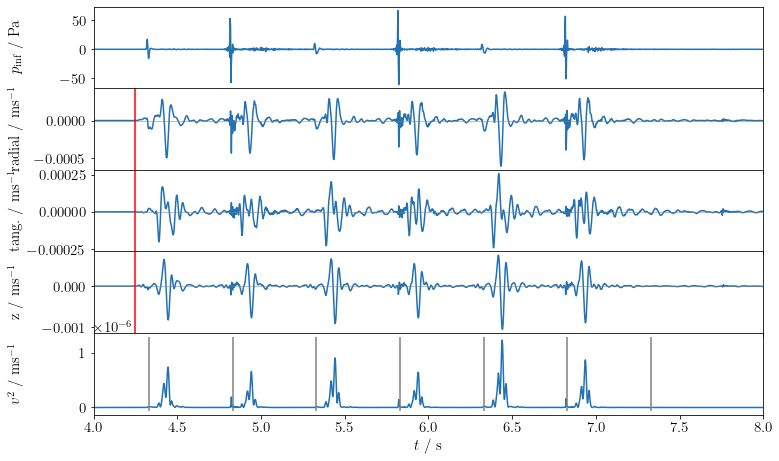

In [55]:
fig, axs = infseis_plot(infsig[1], seissig[1], t_u, tblast2)
ax = axs[-1]
ax.vlines(intvs[1], *ax.get_ylim(), colors='gray')
ax.set_xlim(4, 8)
# fig

(4.0, 8.0)

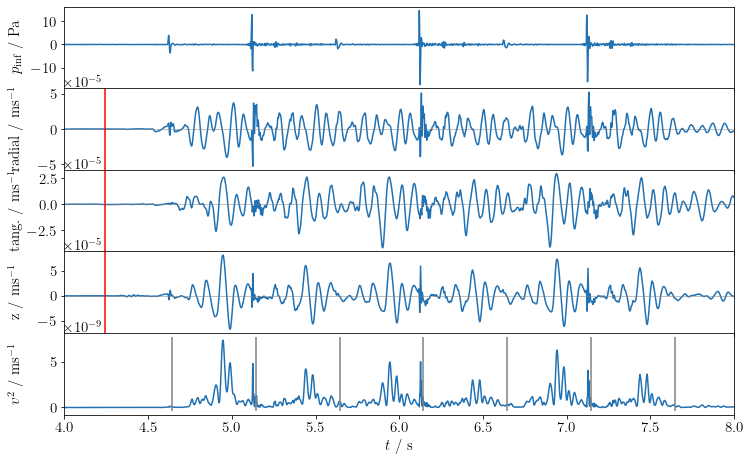

In [56]:
fig, axs = infseis_plot(infsig[3], seissig[3], t_u, tblast2)
ax = axs[-1]
ax.vlines(intvs[3], *ax.get_ylim(), colors='gray')
ax.set_xlim(4, 8)
# fig

In [57]:
intvsq['pad2']

{'tot': {1: 1.5114939045633144e-07,
  3: 2.7110037365964322e-09,
  4: 1.6548165358372305e-09,
  5: 1.7322643621549392e-09,
  6: 4.4282000847600334e-10,
  7: 2.6223526938492637e-10},
 1: {1: 2.3911121288294559e-08, 3: 5.7221164002865302e-10},
 2: {1: 1.8416854192347757e-08, 3: 4.0112202434421884e-10},
 3: {1: 2.7226673854874601e-08, 3: 4.6305559955026003e-10},
 4: {1: 1.8676499684640748e-08, 3: 3.1184533614572742e-10},
 5: {1: 3.7280465571063968e-08, 3: 5.2614971149921982e-10},
 6: {1: 2.4808459344950429e-08, 3: 3.428649208855202e-10}}

In [58]:
def ea_es_plot(inf, seis, t, figaxs=None, set_size=True, pci=0):
    if figaxs is None:
        fig, axs = plt.subplots(nrows=2, sharex=True)
    else:
        fig, axs = figaxs
    ax1, ax2 = axs
    ax1.plot(t, inf ** 2, color=pltt[pci])
    ax1.set_ylabel(r'$p^2\ /\ \mathrm{Pa^2}$')
    vsq = np.zeros(len(seis['hhz']))
    for comp in ['hhn', 'hhe', 'hhz']:
        vsq += seis[comp] ** 2
    ax2.plot(t, vsq * 1e6, color=pltt[pci])
    ax2.set_ylabel(r'$u^2\ /\ 10^{-6}\mathrm{m^2s^{-2}}$')
    ax2.set_xlabel(r'$t\ /\ \mathrm{s}$')
    fig.subplots_adjust(hspace=0)
    if set_size:
        fig.set_size_inches(6.5, 8)
    return fig, axs

In [59]:
infsig_p2 = infsig
seissig_p2 = seissig
t_u_p2 = t_u

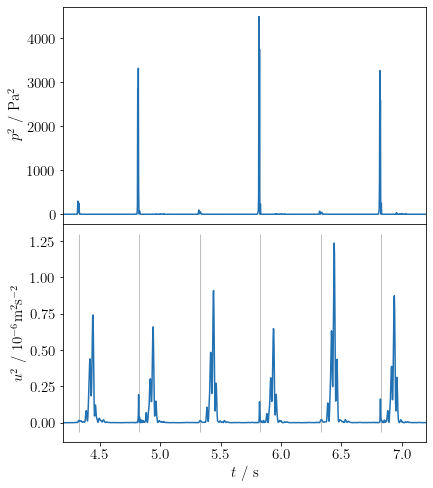

In [60]:
fig, axs = ea_es_plot(infsig[1], seissig[1], t_u)
axs[-1].set_xlim(4.2, 7.2)
axs[-1].vlines(intvs[1], *axs[-1].get_ylim(), color='gray', lw=.5, zorder=-1)
# fig

In [61]:
intvsq['pad2']['r'] = dst

## Pad 3

In [62]:
plt.close('all')

In [63]:
dst = dist['pad3'].copy()
dst.pop(2)
dst['xmb'] = dst['xmbm']
dst

{1: 23.171533054699974,
 3: 133.97256873676304,
 4: 184.83824108158149,
 5: 231.77213253005777,
 6: 282.5527883629108,
 7: 323.56113745109036,
 'xmbm': 29.191457694104695,
 'xmbd': 29.191457694104695,
 'xmb': 29.191457694104695}

### Organize and Filter Data

In [64]:
mtuloc = Path('../data/MTU_seis_infr/compact/')

In [65]:
BPPARS = [.1, .25, 180, 200]

In [66]:
pad = 'pad3'
t_u = ucsb[pad]['t'][:]
t_m = obspy.read(str(mtuloc / 'Shot3SAC/Shot3_XMBD_HH1.sac'))[0].times()

infsig, seissig = {}, {}

# UCSB data
for k, (k1, k2) in infmap.items():
    infsig[k] = highpass(ucsb['pad3']['inf'][k1][k2], SRATE_U, freq=1., half_ord=1)
for k, v in ucsb['pad3']['seis'].items():
    seissig[k] = {}
    for comp, vv in v.items():
        seissig[k][comp] = highpass(vv, SRATE_U, freq=1 / 10, half_ord=1)
# MTU data
d = obspy.read(str(mtuloc / 'Shot3SAC/Shot3_XMBI_HDF.sac'))[0]
d.remove_response(inventory=inv, pre_filt=[.5, .9, 190, 220], water_level=None)
infsig['xmbi'] = d.data
for k in ('XMBM', 'XMBD'):
    seissig[k.lower()] = {}
    for comp in ('HH1', 'HH2', 'HHZ'):
        d = obspy.read(str(mtuloc / f'Shot3SAC/Shot3_{k}_{comp}.sac'))[0]
        d.remove_response(inventory=inv, pre_filt=BPPARS, water_level=None)
        seissig[k.lower()][comp.lower()] = d.data

Estimate of shot time from infrasound signal. Speed of sound comes from acoustic microphones (`mics_c.ipynb`). Distance is from last station.

In [67]:
tas = 8.7477
tshot3 = tas - dst[7] / cs[3]
tshot3

7.8209376861167499

In [68]:
blastpoint3 = cratercoords[3].sum(axis=0) / 3
blastpoint3

x    23.183333
y    50.187333
z    -1.266667
dtype: float64

Estimate of shot time from infrasound signal. Speed of sound comes from acoustic microphones (`mics_c.ipynb`).

In [69]:
pickt = 7.8826
tblast3 = pickt - dst[1] / cs[3]
tblast3

7.8162307698780973

In [70]:
pickt = 0.7466
pickt - dst['xmbm'] / cs[3]

0.66298815745508721

In [71]:
tblast3_m = pickt - dst['xmbm'] / cs[3]
tblast3_m

0.66298815745508721

### Energy

In [72]:
plt.close('all')

In [73]:
sstations = (1, 3, 4, 5, 6, 7, 'xmbm', 'xmbd')

#### Total time interval

In [74]:
intvsq['pad3']

{'tot': {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}

In [75]:
tst, ten = tblast3, tblast3 + 7.5
for station in sstations[:-2]:
    seis = seissig[station]
    ivsq = integrate_vsq(seis, t_u, tst, ten)
    intvsq['pad3']['tot'][station] = ivsq
    print(f"{station}: tst={tst:.2f} s, ten={ten:.2f} s, int(vsq)={ivsq:.3e} m^2/s")
tst, ten = tblast3_m, tblast3_m + 7.5
for station in sstations[-2:]:
    seis = seissig[station]
    ivsq = integrate_vsq(seis, t_m, tst, ten)
    intvsq['pad3']['tot'][station] = ivsq
    print(f"{station}: tst={tst:.2f} s, ten={ten:.2f} s, int(vsq)={ivsq:.3e} m^2/s")

1: tst=7.82 s, ten=15.32 s, int(vsq)=2.771e-07 m^2/s
3: tst=7.82 s, ten=15.32 s, int(vsq)=5.145e-09 m^2/s
4: tst=7.82 s, ten=15.32 s, int(vsq)=3.518e-09 m^2/s
5: tst=7.82 s, ten=15.32 s, int(vsq)=3.574e-09 m^2/s
6: tst=7.82 s, ten=15.32 s, int(vsq)=9.331e-10 m^2/s
7: tst=7.82 s, ten=15.32 s, int(vsq)=5.173e-10 m^2/s
xmbm: tst=0.66 s, ten=8.16 s, int(vsq)=2.145e-07 m^2/s
xmbd: tst=0.66 s, ten=8.16 s, int(vsq)=1.056e-07 m^2/s


Skip station \#2, since z-component broken

#### Per-Blast intervals (for stations \#1, 3)

In [76]:
inter = arr([0., .5, 1., 1.5, 2., 2.5, 3.])
intvs = {1: tblast3 + inter, 3: tblast3 + 0.4 + inter,
         'xmbm': tblast3_m + inter, 'xmbd': tblast3_m + inter}
intvs

{1: array([  7.81623077,   8.31623077,   8.81623077,   9.31623077,
          9.81623077,  10.31623077,  10.81623077]),
 3: array([  8.21623077,   8.71623077,   9.21623077,   9.71623077,
         10.21623077,  10.71623077,  11.21623077]),
 'xmbm': array([ 0.66298816,  1.16298816,  1.66298816,  2.16298816,  2.66298816,
         3.16298816,  3.66298816]),
 'xmbd': array([ 0.66298816,  1.16298816,  1.66298816,  2.16298816,  2.66298816,
         3.16298816,  3.66298816])}

In [77]:
intvsq['pad3']

{'tot': {1: 2.7707598202934718e-07,
  3: 5.145140773318411e-09,
  4: 3.5178207715583736e-09,
  5: 3.5743724139731571e-09,
  6: 9.3310781926427837e-10,
  7: 5.1728609463432564e-10,
  'xmbm': 2.1451791757949288e-07,
  'xmbd': 1.0560911462397393e-07},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {}}

In [78]:
for st, t in zip((1, 3, 'xmbm', 'xmbd'), (t_u, t_u, t_m, t_m)):
    for blast, (tst, ten) in enumerate(zip(intvs[st][:-1], intvs[st][1:]), start=1):
        intvsq['pad3'][blast][st] = integrate_vsq(seissig[st], t, tst, ten)

In [79]:
seissig[1]

{'hhe': array([ -9.43976147e-08,  -1.53460647e-07,  -2.15631246e-07, ...,
         -1.82709536e-07,  -1.08602069e-07,  -5.62451815e-08]),
 'hhn': array([  1.19978588e-07,   6.42915782e-08,   8.00700369e-08, ...,
         -8.58945238e-08,  -6.77774336e-08,  -9.31611341e-08]),
 'hhz': array([  4.81387923e-08,   3.89033004e-08,  -1.38327190e-08, ...,
         -9.41514665e-08,  -8.51007867e-08,  -6.98359421e-08])}

(7.5, 11.5)

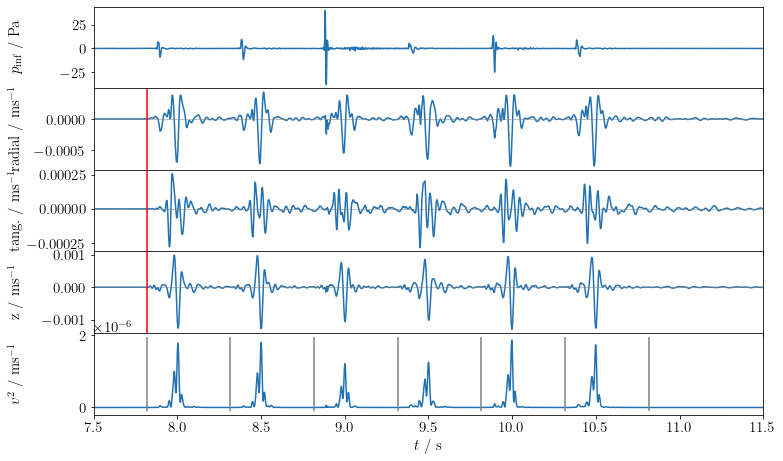

In [80]:
fig, axs = infseis_plot(infsig[1], seissig[1], t_u, tblast3)
ax = axs[-1]
ax.vlines(intvs[1], *ax.get_ylim(), colors='gray')
ax.set_xlim(7.5, 11.5)
# fig

(7.5, 11.5)

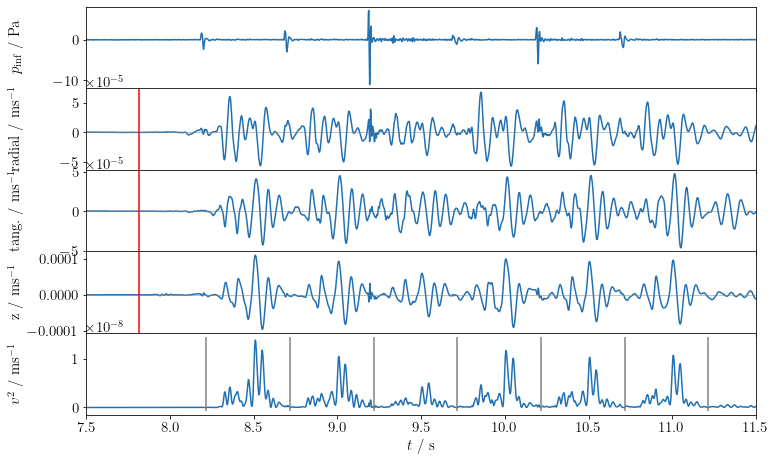

In [81]:
fig, axs = infseis_plot(infsig[3], seissig[3], t_u, tblast3)
ax = axs[-1]
ax.vlines(intvs[3], *ax.get_ylim(), colors='gray')
ax.set_xlim(7.5, 11.5)
# fig

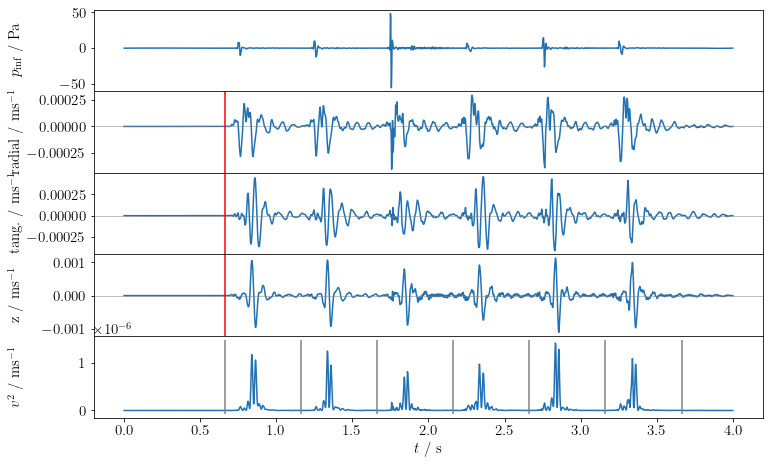

In [82]:
fig, axs = infseis_plot(infsig['xmbi'], seissig['xmbm'], t_m, tblast3_m)
ax = axs[-1]
ax.vlines(intvs['xmbm'], *ax.get_ylim(), colors='gray')
# ax.set_xlim(7.5, 11.5)
# fig

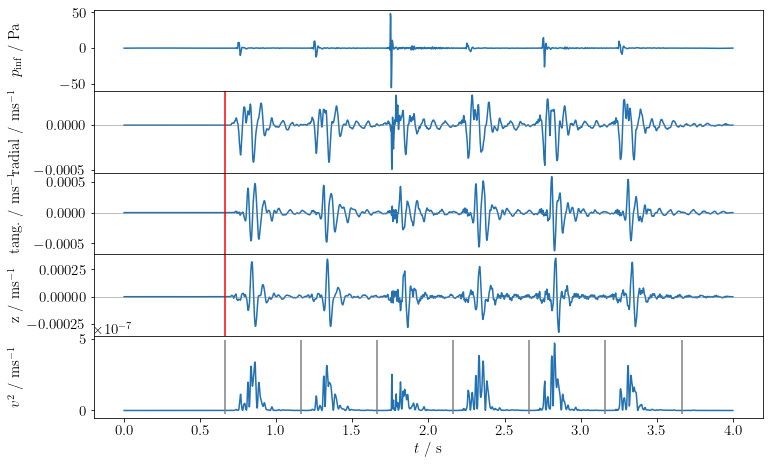

In [83]:
fig, axs = infseis_plot(infsig['xmbi'], seissig['xmbd'], t_m, tblast3_m)
ax = axs[-1]
ax.vlines(intvs['xmbd'], *ax.get_ylim(), colors='gray')
# fig

In [84]:
intvsq['pad3']['r'] = dst

In [85]:
intvsq['pad3']

{'tot': {1: 2.7707598202934718e-07,
  3: 5.145140773318411e-09,
  4: 3.5178207715583736e-09,
  5: 3.5743724139731571e-09,
  6: 9.3310781926427837e-10,
  7: 5.1728609463432564e-10,
  'xmbm': 2.1451791757949288e-07,
  'xmbd': 1.0560911462397393e-07},
 1: {1: 5.1402829003351884e-08,
  3: 1.0889778076234448e-09,
  'xmbm': 4.0863578824695192e-08,
  'xmbd': 1.961462919157347e-08},
 2: {1: 4.939344773845064e-08,
  3: 8.6465101399519784e-10,
  'xmbm': 3.6584848400013914e-08,
  'xmbd': 1.6643986983711843e-08},
 3: {1: 3.3635348243571247e-08,
  3: 4.4444424651163577e-10,
  'xmbm': 2.5549058417184427e-08,
  'xmbd': 1.0872896186842434e-08},
 4: {1: 4.0662386037003171e-08,
  3: 9.5046661621007512e-10,
  'xmbm': 3.4412223437823269e-08,
  'xmbd': 2.1354457702953424e-08},
 5: {1: 5.1091737009502245e-08,
  3: 8.0354051933234379e-10,
  'xmbm': 4.1425663215267287e-08,
  'xmbd': 2.0990674285872003e-08},
 6: {1: 5.0576737559008535e-08,
  3: 8.4240686118008839e-10,
  'xmbm': 3.5427925687031167e-08,
  'xmbd'

## Pad 4

In [86]:
plt.close('all')

In [87]:
dst = dist['pad4'].copy()
dst.pop(2)
dst['xmb'] = dst['xmbm']
dst

{1: 23.519355779691661,
 3: 134.21994156627738,
 4: 185.08715179887767,
 5: 232.0061350673559,
 6: 282.7890448596138,
 7: 323.8063239098928,
 'xmbm': 29.719201544429403,
 'xmbd': 29.719201544429403,
 'xmb': 29.719201544429403}

### Organize and Filter Data

In [88]:
pad = 'pad4'
t_u = ucsb[pad]['t'][:]
t_m = obspy.read(str(mtuloc / 'Shot4SAC/Shot4_XMBD_HH1.sac'))[0].times()

infsig, seissig = {}, {}

# UCSB data
for k, (k1, k2) in infmap.items():
    infsig[k] = highpass(ucsb['pad4']['inf'][k1][k2], SRATE_U, freq=1., half_ord=1)
for k, v in ucsb['pad4']['seis'].items():
    seissig[k] = {}
    for comp, vv in v.items():
        seissig[k][comp] = highpass(vv, SRATE_U, freq=1 / 10, half_ord=1)
# MTU data
d = obspy.read(str(mtuloc / 'Shot4SAC/Shot4_XMBI_HDF.sac'))[0]
d.remove_response(inventory=inv, pre_filt=[.5, .9, 190, 220], water_level=None)
infsig['xmbi'] = d.data
for k in ('XMBM', 'XMBD'):
    seissig[k.lower()] = {}
    for comp in ('HH1', 'HH2', 'HHZ'):
        d = obspy.read(str(mtuloc / f'Shot4SAC/Shot4_{k}_{comp}.sac'))[0]
        d.remove_response(inventory=inv, pre_filt=BPPARS, water_level=None)
        seissig[k.lower()][comp.lower()] = d.data

Estimate of shot time from infrasound signal. Speed of sound comes from acoustic microphones (`mics_c.ipynb`).

In [89]:
tas = 4.454
tshot4 = tas - dst[7] / cs[4]
tshot4

3.5298607641525557

In [90]:
pickt = 3.5872
tblast4 = pickt - dst[1] / cs[4]
tblast4

3.5200760500554131

`XMBM`

In [91]:
pickt = 0.5922
pickt - dst['xmbm'] / cs[4]

0.50738176707102267

In [92]:
tblast4_m = pickt - dst['xmbm'] / cs[4]
tblast4_m

0.50738176707102267

### Energy

#### Total time interval

In [93]:
tst, ten = tblast4, tblast4 + 7.5
for station in sstations[:-2]:
    seis = seissig[station]
    ivsq = integrate_vsq(seis, t_u, tst, ten)
    intvsq['pad4']['tot'][station] = ivsq
    print(f"{station}: tst={tst:.2f} s, ten={ten:.2f} s, int(vsq)={ivsq:.3e} m^2/s")
tst, ten = tblast4_m, tblast4_m + 7.5
for station in sstations[-2:]:
    seis = seissig[station]
    ivsq = integrate_vsq(seis, t_m, tst, ten)
    intvsq['pad4']['tot'][station] = ivsq
    print(f"{station}: tst={tst:.2f} s, ten={ten:.2f} s, int(vsq)={ivsq:.3e} m^2/s")
# intvsq['pad4']['tot']['xmb'] = DW[0] * intvsq['pad4']['tot']['xmbm'] \
#                                 + DW[1] * intvsq['pad4']['tot']['xmbd']

1: tst=3.52 s, ten=11.02 s, int(vsq)=1.383e-07 m^2/s
3: tst=3.52 s, ten=11.02 s, int(vsq)=2.778e-09 m^2/s
4: tst=3.52 s, ten=11.02 s, int(vsq)=1.995e-09 m^2/s
5: tst=3.52 s, ten=11.02 s, int(vsq)=2.212e-09 m^2/s
6: tst=3.52 s, ten=11.02 s, int(vsq)=4.718e-10 m^2/s
7: tst=3.52 s, ten=11.02 s, int(vsq)=2.908e-10 m^2/s
xmbm: tst=0.51 s, ten=8.01 s, int(vsq)=1.678e-07 m^2/s
xmbd: tst=0.51 s, ten=8.01 s, int(vsq)=8.000e-08 m^2/s


#### Per-Blast intervals (for stations \#1, 3)

In [94]:
inter = arr([0., .5, 1., 1.5, 2., 2.5, 3.])
intvs = {1: tblast4 + inter, 3: tblast4 + .37 + inter,
         'xmbm': tblast4_m + inter, 'xmbd': tblast4_m + inter}
intvs

{1: array([ 3.52007605,  4.02007605,  4.52007605,  5.02007605,  5.52007605,
         6.02007605,  6.52007605]),
 3: array([ 3.89007605,  4.39007605,  4.89007605,  5.39007605,  5.89007605,
         6.39007605,  6.89007605]),
 'xmbm': array([ 0.50738177,  1.00738177,  1.50738177,  2.00738177,  2.50738177,
         3.00738177,  3.50738177]),
 'xmbd': array([ 0.50738177,  1.00738177,  1.50738177,  2.00738177,  2.50738177,
         3.00738177,  3.50738177])}

In [95]:
seissig.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 'xmbm', 'xmbd'])

In [96]:
for st, t in zip((1, 3, 'xmbm', 'xmbd'), (t_u, t_u, t_m, t_m)):
    for blast, (tst, ten) in enumerate(zip(intvs[st][:-1], intvs[st][1:]), start=1):
        intvsq['pad4'][blast][st] = integrate_vsq(seissig[st], t, tst, ten)

(3.0, 7.0)

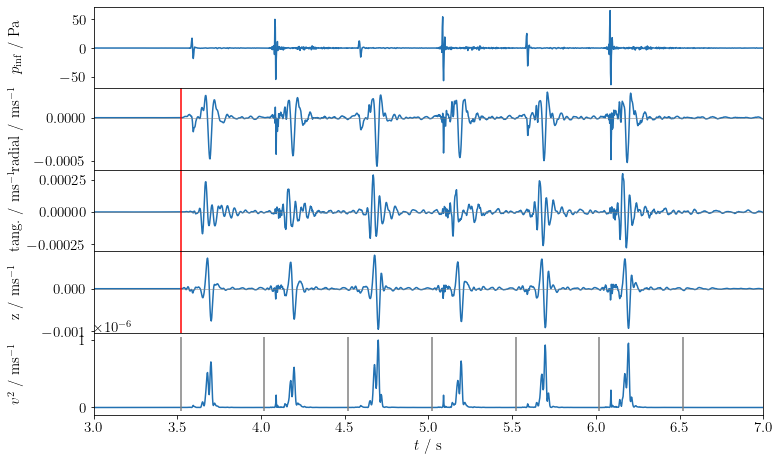

In [97]:
fig, axs = infseis_plot(infsig[1], seissig[1], t_u, tblast4)
ax = axs[-1]
ax.vlines(intvs[1], *ax.get_ylim(), colors='gray')
ax.set_xlim(3, 7)
# fig

(3.0, 7.0)

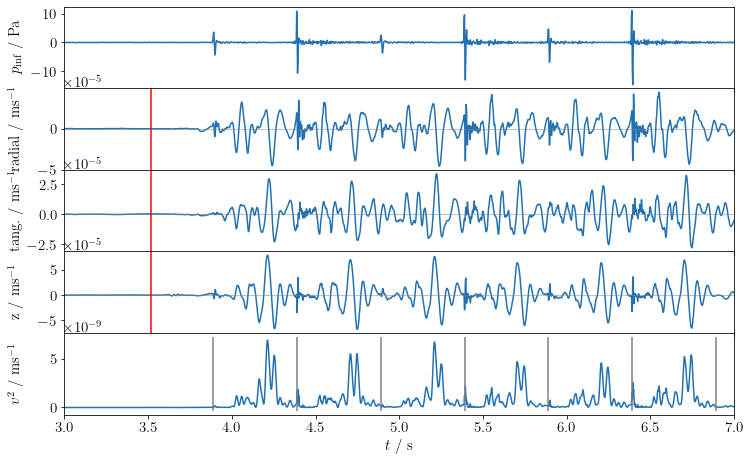

In [98]:
fig, axs = infseis_plot(infsig[3], seissig[3], t_u, tblast4)
ax = axs[-1]
ax.vlines(intvs[3], *ax.get_ylim(), colors='gray')
ax.set_xlim(3, 7)
# fig

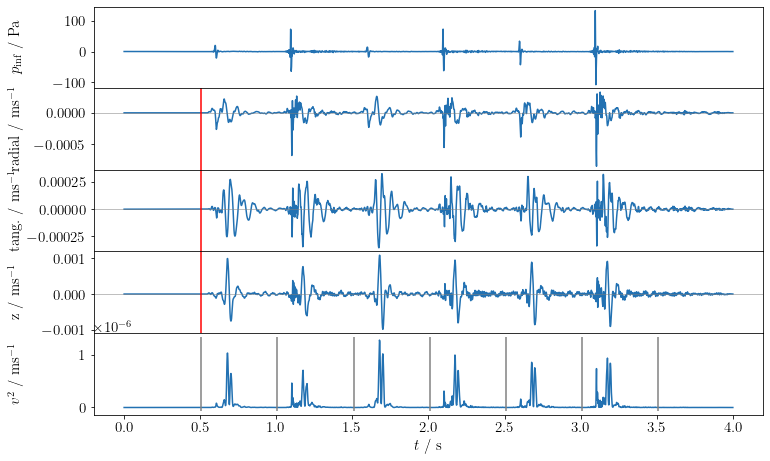

In [99]:
fig, axs = infseis_plot(infsig['xmbi'], seissig['xmbm'], t_m, tblast4_m)
ax = axs[-1]
ax.vlines(intvs['xmbm'], *ax.get_ylim(), colors='gray')
# fig

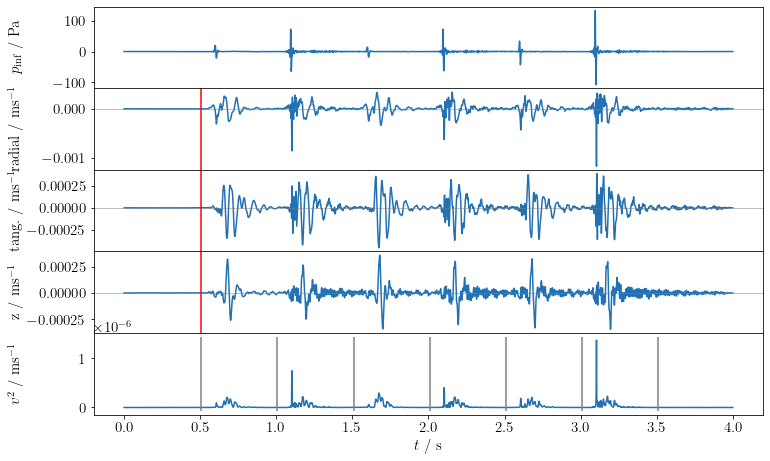

In [100]:
fig, axs = infseis_plot(infsig['xmbi'], seissig['xmbd'], t_m, tblast4_m)
ax = axs[-1]
ax.vlines(intvs['xmbd'], *ax.get_ylim(), colors='gray')
# fig

In [101]:
intvsq['pad4']['r'] = dst

## `xmb` Entry:

Interpolate between medium and deep MTU station.
$w_d$ (`WD`) is the depth weight factor that minimizes the sum of square differences of the per-blast seismic energies, assuming same proportionality factor $F$.

In [102]:
ivsq_a = arr(
    [intvsq['pad3']['r'][1] ** 2 * intvsq['pad3'][i][1] for i in range(1, 7)]
  + [intvsq['pad4']['r'][1] ** 2 * intvsq['pad4'][i][1] for i in range(1, 7)]
)
ivsq_b = arr(
    [intvsq['pad3']['r']['xmbm'] ** 2 * intvsq['pad3'][i]['xmbm'] for i in range(1, 7)]
  + [intvsq['pad4']['r']['xmbm'] ** 2 * intvsq['pad4'][i]['xmbm'] for i in range(1, 7)]
)
ivsq_c = arr(
    [intvsq['pad3']['r']['xmbd'] ** 2 * intvsq['pad3'][i]['xmbd'] for i in range(1, 7)]
  + [intvsq['pad4']['r']['xmbd'] ** 2 * intvsq['pad4'][i]['xmbd'] for i in range(1, 7)]
)
def dsq(a):
    if np.isscalar(a):
        a = arr([[a]])
        index = True
    else:
        a = a[:, None]
        index = False
    ret = np.sum((ivsq_a - (a * ivsq_b + (1 - a) * ivsq_c)) ** 2, axis=1)
    return ret[0] if index else ret

In [103]:
arg = np.linspace(0, 1, 10000)
WD = arg[np.argmin(dsq(arg))]
WD

0.41444144414441447

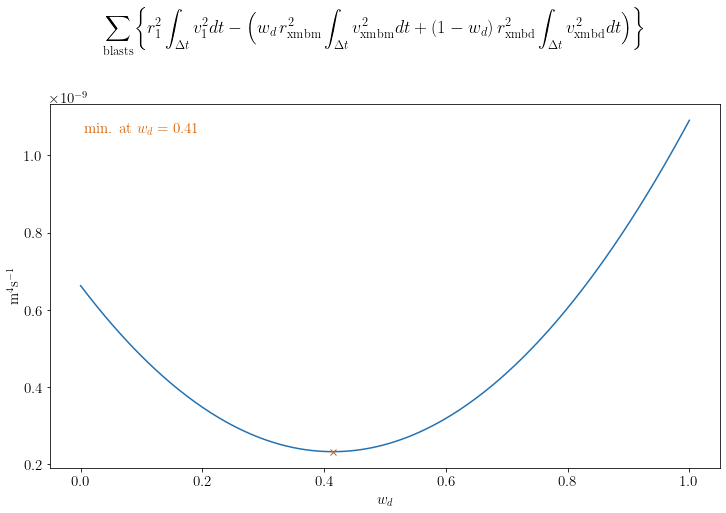

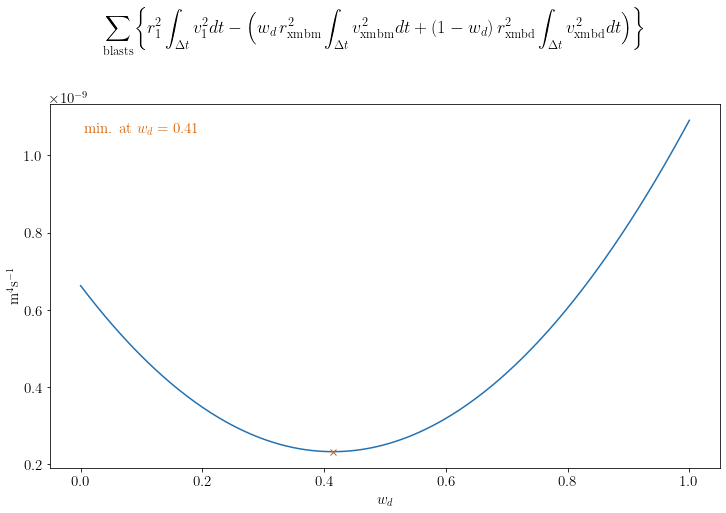

In [104]:
fig, ax = plt.subplots()

xp = np.linspace(0, 1, 300)
ax.plot(xp, dsq(xp))
ax.plot([WD,], [dsq(WD)], 'x')
ax.set_xlabel(r'$w_d$')
ax.set_ylabel(r'$\mathrm{m^4s^{-1}}$')
ax.text(.05, .95, s=r'min. at $w_d=%.2f$' % WD, color=pltt[1],
        ha='left', va='top', transform=ax.transAxes)
fig.suptitle(
    r'$$\sum_\text{blasts}\biggl\{'
    r'r_1^2\int_{\Delta t}v_1^2 dt '
    r'- \Bigl(w_d\, r_\text{xmbm}^2\int_{\Delta t}v_\text{xmbm}^2 dt'
    r'+ (1 - w_d)\, r_\text{xmbd}^2\int_{\Delta t}v_\text{xmbd}^2 dt'
    r'\Bigr)\biggr\}$$'
)
fig.subplots_adjust(top=.8)
fig

In [105]:
intvsq['pad3']['tot']['xmb'] = WD * intvsq['pad3']['tot']['xmbm'] \
                                + (1 - WD) * intvsq['pad3']['tot']['xmbd']
intvsq['pad4']['tot']['xmb'] = WD * intvsq['pad4']['tot']['xmbm'] \
                                + (1 - WD) * intvsq['pad4']['tot']['xmbd']

for blast in range(1, 7):
    intvsq['pad3'][blast]['xmb'] = WD * intvsq['pad3'][blast]['xmbm'] \
                                    + (1 - WD) * intvsq['pad3'][blast]['xmbd']
    intvsq['pad4'][blast]['xmb'] = WD * intvsq['pad4'][blast]['xmbm'] \
                                    + (1 - WD) * intvsq['pad4'][blast]['xmbd']

In [106]:
plt.close('all')

## Energy

There are two ways the data allows to be analyzed: Per-blast integration of $v^2$, and the total blast sequence. Radial dependency is only available for the integrated (cumulative) blast sequence.

Seismic energy in a homogeneous half space:

$$
E_\text{s} = 2\pi r^2 \frac{\rho_\text{gr}c_\text{gr}}{A} \int S^2 v^2 dt
$$

The site response $S$ is assumed to be independent of time and location (is excluded from integration).
Then

$$
E_\text{s} = F\,r^2 \int v^2 dt
\quad,\quad
F = 2\pi\rho_\text{gr}c_\text{gr}\frac{S^2}{A}
$$

#### `acc`

Collect values of $E_\text{a}$ and make sure that they are unique for each blast accross the channels.

In [107]:
acc = {}
for pad in (1, 2, 3, 4):
    el = {}
    for blast in range(1, 7):
        sel = msumm.query(f'pad == {pad} & blast == {blast} & hlabel == "h"')
        for eu in sel['Ea'].unique():
            if not np.isnan(eu):
                sel1 = sel.loc[sel.Ea == eu]
                el[f"blast{blast}"] = {
                    'Ea': sel1['Ea'].iloc[1], 'σEa': sel1['σEa'].iloc[1],
                    'ch': sel1['c'].values, 'r': sel1['r'].values,
                    'dredbar': sel1['dredbar'].values
                }
                print(sel1[['pad', 'blast', 'ch', 'r', 'Ea', 'σEa']])
    el['Ea_avg'] = asarray([el[blast]['Ea'] for blast in el.keys()]).mean()
    acc[f"pad{pad}"] = el

     pad  blast  ch           r           Ea         σEa
36     1      1   7   31.218248  4315.675633  518.018995
90     1      1  17   82.669445  4315.675633  518.018995
102    1      1  19  130.277588  4315.675633  518.018995
108    1      1  21  180.200583  4315.675633  518.018995
126    1      1  25  230.157012  4315.675633  518.018995
138    1      1  27  280.128988  4315.675633  518.018995
     pad  blast  ch           r           Ea         σEa
37     1      2   7   31.218248  4476.806545  801.667063
91     1      2  17   82.669445  4476.806545  801.667063
103    1      2  19  130.277588  4476.806545  801.667063
109    1      2  21  180.200583  4476.806545  801.667063
127    1      2  25  230.157012  4476.806545  801.667063
139    1      2  27  280.128988  4476.806545  801.667063
     pad  blast  ch           r           Ea         σEa
38     1      3   7   31.218248  3884.825891  505.385014
92     1      3  17   82.669445  3884.825891  505.385014
104    1      3  19  130.277588

In [108]:
acc['pad1']['blast1']

{'Ea': 4315.6756326751556,
 'σEa': 518.01899521925031,
 'ch': array([ 341.2903598,  341.2903598,  341.2903598,  341.2903598,
         341.2903598,  341.2903598]),
 'r': array([  31.21824821,   82.66944457,  130.27758825,  180.20058268,
         230.15701162,  280.12898815]),
 'dredbar': array([ 0.00395482,  0.00395482,  0.00395482,  0.00395482,  0.00395482,
         0.00395482])}

In [109]:
fit_dr = {}

for pad in (1, 2, 3, 4):
    ps = f"pad{pad}"
    d, ea, σea, blasts, dredbar, σdredbar = intvsq[ps], [], [], [], [], []
    stations = (1, ) if pad in (1, 2) else (1, 'xmbm', 'xmbd')
    ys = {st: [] for st in stations}
    r = {st: d['r'][st] for st in stations}
    for blast in range(1, 7):
        bs = f"blast{blast}"
        try:
            el = acc[ps][bs]
            ea.append(el['Ea'])
            σea.append(el['σEa'])
            dredbar.append(el['dredbar'].mean())
        except KeyError as err:
            print(f'skipping pad {pad}, {err.args[0]}')
            continue
        blasts.append(blast)
        for st in stations:
            ys[st].append(d[blast][st])
    ea, blasts, dredbar = arr(ea), arr(blasts), arr(dredbar)
    for st, y in ys.items():
        ys[st] = asarray(y)
    if len(stations) > 1:
        ys['xmb'] = 0.5 * (ys['xmbm'] + ys['xmbd'])
        r['xmb'] = r['xmbm']
    fit_dr[ps] = {'blasts': blasts, 'ea': ea, 'dredbar': dredbar,
                  'intvs': ys, 'r': r}

skipping pad 2, blast3


In [110]:
fit_dr

{'pad1': {'blasts': array([1, 2, 3, 4, 5, 6]),
  'ea': array([ 4315.67563268,  4476.806545  ,  3884.82589146,  1705.38794177,
          2593.53781845,  1848.01916328]),
  'dredbar': array([ 0.00395482,  0.00395482,  0.00395482,  0.00482697,  0.0044256 ,
          0.00482788]),
  'intvs': {1: array([  3.48556056e-08,   3.34043844e-08,   3.30200448e-08,
            3.22970307e-08,   2.35323122e-08,   2.40776321e-08])},
  'r': {1: 26.852655606554741}},
 'pad2': {'blasts': array([1, 2, 4, 5, 6]),
  'ea': array([  7919.23457089,  32621.26470708,  33367.09170936,   4137.38443352,
          28917.70211361]),
  'dredbar': array([ 0.00395482,  0.00223917,  0.00189186,  0.00395482,  0.00208641]),
  'intvs': {1: array([  2.39111213e-08,   1.84168542e-08,   1.86764997e-08,
            3.72804656e-08,   2.48084593e-08])},
  'r': {1: 24.321774258879273}},
 'pad3': {'blasts': array([1, 2, 3, 4, 5, 6]),
  'ea': array([  6172.58571358,   6276.7945657 ,  16100.96907089,   3129.20086792,
           6791.

### Per Pad at Station \#1

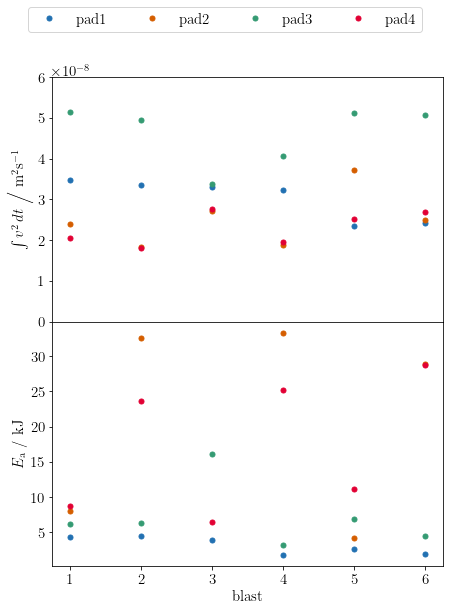

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 9), sharex=True)

for pad, clr in zip(intvsq.keys(), pltt[:4]):
    x, d = list(range(1, 7)), intvsq[pad]
    y = [d[i][1] for i in x]
    ax1.plot(x, y, '.', color=clr, ms=10, label=pad)
    try:
        ax2.plot(fit_dr[pad]['blasts'], fit_dr[pad]['ea'] / 1e3,
                 '.', color=clr, ms=10)
    except KeyError:
        pass
ax2.set_xlabel(r'blast')
fig.legend(loc='upper center', ncol=4)
ax1.set_ylabel(r'$\Bigl.\int v^2\, dt\ \Bigr/\ \mathrm{m^2s^{-1}}$')
ax2.set_ylabel(r'$E_\text{a}\ /\ \mathrm{kJ}$')
ax1.set_ylim(0, 6e-8)
# ax2.set_ylim(0, 38)
fig.subplots_adjust(hspace=0)
# fig

### Cumulative Along Radial Line

- Overall seismic energy of pad 2 is smaller compared to pad 1.
- Overall seismic energy of pad 4 is smaller compared to pad 3.

In [112]:
intvsq['pad1']

{'tot': {1: 1.8152939637472003e-07,
  3: 4.4347093766472294e-09,
  4: 3.1996488402766493e-09,
  5: 2.6000612980567226e-09,
  6: 7.3504431032794583e-10,
  7: 4.1872020085156253e-10},
 1: {1: 3.4855605626544515e-08, 3: 7.6952993000139031e-10},
 2: {1: 3.3404384392530032e-08, 3: 6.496302538695404e-10},
 3: {1: 3.30200448007441e-08, 3: 6.8960792598900942e-10},
 4: {1: 3.229703068299395e-08, 3: 6.8663625273648827e-10},
 5: {1: 2.3532312217544698e-08, 3: 6.8304716916611379e-10},
 6: {1: 2.4077632136469972e-08, 3: 7.3926846675811259e-10},
 'r': {1: 26.852655606554741,
  3: 135.49609734855588,
  4: 186.31660087758621,
  5: 233.00799435232838,
  6: 283.81079245158338,
  7: 324.94944039172429,
  'xmbm': 36.143370817014535,
  'xmbd': 36.143370817014535}}

In [113]:
stations

(1, 'xmbm', 'xmbd')

Text(0, 0.5, '$\\Bigl.\\int_0^\\infty v^2dt\\Bigr/ \\mathrm{m^2s^{-1}}$')

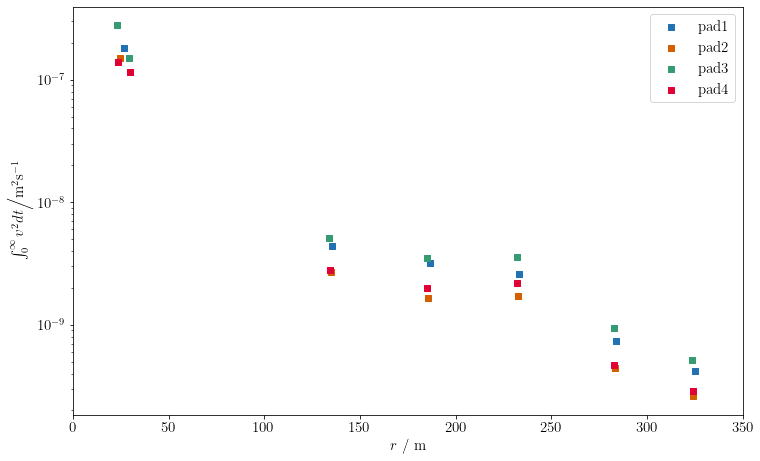

In [114]:
fig, ax = plt.subplots()
stations = [1, 3, 4, 5, 6, 7, 'xmb']

for pad, dta in intvsq.items():
    sta = stations if 'xmb' in dta['tot'].keys() else stations[:-1]
    x = [dta['r'][st] for st in sta]
    y = [dta['tot'][st] for st in sta]
    ax.scatter(x, y, marker='s', label=pad)
ax.set_yscale('log')
ax.set_xlim(0, 350)
ax.legend(loc='upper right')
ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
ax.set_ylabel(r'$\Bigl.\int_0^\infty v^2dt\Bigr/ \mathrm{m^2s^{-1}}$')
# fig

In [115]:
msumm.columns

Index(['pad', 'ch', 'blast', 'pmax', 'tmax', 'pmin', 'tmin', 'noise', 'ts',
       'tarr', 't1', 't2', 'imp1', 'imp2', 'imp', 'm1', 'm2', 'r', 'x', 'y',
       'z', 'hlabel', 'ppf46', 'alpha', 'depth', 'dbar', 'dredbar', 't', 'c',
       'Ea', 'σEa'],
      dtype='object')

In [116]:
intvsq['pad1']

{'tot': {1: 1.8152939637472003e-07,
  3: 4.4347093766472294e-09,
  4: 3.1996488402766493e-09,
  5: 2.6000612980567226e-09,
  6: 7.3504431032794583e-10,
  7: 4.1872020085156253e-10},
 1: {1: 3.4855605626544515e-08, 3: 7.6952993000139031e-10},
 2: {1: 3.3404384392530032e-08, 3: 6.496302538695404e-10},
 3: {1: 3.30200448007441e-08, 3: 6.8960792598900942e-10},
 4: {1: 3.229703068299395e-08, 3: 6.8663625273648827e-10},
 5: {1: 2.3532312217544698e-08, 3: 6.8304716916611379e-10},
 6: {1: 2.4077632136469972e-08, 3: 7.3926846675811259e-10},
 'r': {1: 26.852655606554741,
  3: 135.49609734855588,
  4: 186.31660087758621,
  5: 233.00799435232838,
  6: 283.81079245158338,
  7: 324.94944039172429,
  'xmbm': 36.143370817014535,
  'xmbd': 36.143370817014535}}

### Fit Data

In [117]:
def sq_inverse(x, a):
    return a / x ** 2

def linear(x, a, y0):
    return a * x + y0

#### Cumulative

Fit cumulative data to $\propto r^{-2}$.

In [118]:
bc = {}
stations = [1, 3, 4, 5, 6, 7, 'xmb']
for pad in (1, 2, 3, 4):
    d = intvsq[f'pad{pad}']
    sta = stations if 'xmb' in d['tot'].keys() else stations[:-1]
    res = curve_fit(
        lambda x, y0: linear(x, -2, y0),
        np.log(asarray([d['r'][st] for st in sta])),
        np.log(asarray([d['tot'][st] for st in sta]))
    )
    bc[f'pad{pad}'] = np.e ** res[0][0]
bc

{'pad1': 8.7126368306690029e-05,
 'pad2': 5.3271037457954807e-05,
 'pad3': 0.00010735116458929359,
 'pad4': 6.2401132695558955e-05}

In [119]:
ax.figure.figure.get_dpi()

72.0

In [120]:
def add_char_label(lbl, ax, txtclr='white', bc='#a5a5a5'):
    try:
        dpi = ax.figure.dpi
    except AttributeError:
        dpi = ax.figure.figure.get_dpi()
    pnts = ax.transAxes.transform([(0, 0), (1, 1)])
    sfx = dpi / (72 * (pnts[1, 0] - pnts[0, 0]))
    sfy = dpi / (72 * (pnts[1, 1] - pnts[0, 1]))
    ax.add_artist(plt.Rectangle(
        (-50 * sfx, 1. - 15 * sfy), 11 * sfx, 15 * sfy,
        transform=ax.transAxes, ec='none', fc=bc, clip_on=False
    ))
    ax.text(-45 * sfx, 1 - 8 * sfy, lbl, ha='center', va='center',
            transform=ax.transAxes, color=txtclr)

## Pub Figure

In [121]:
plt.rc('font', size=10)

In [122]:
%%capture
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0)
sfs = fig.subfigures(nrows=2, ncols=1, height_ratios=[3, 4])
sf1, sf2 = sfs[0].subfigures(nrows=1, ncols=2, width_ratios=[4, 3])
sf3, sf4 = sfs[1].subfigures(nrows=1, ncols=2, width_ratios=[4, 3])
# sf3, legfig = tmp.subfigures(nrows=2, height_ratios=[3, 1])
legopts = dict(
    handler_map={tuple: HandlerTuple(ndivide=3)}, loc='lower right', ncol=2,
    bbox_to_anchor=(1.02, -.62), handlelength=6)
lines, labels, mew = [], [], 1.5

In [123]:
axs = sf1.subplots(nrows=2, sharex=True)
sf1.subplots_adjust(left=.16, right=.875, bottom=.13)

ea_es_plot(infsig_p2[1], seissig_p2[1], t_u_p2, (sf1, axs), False, pci=1)
axs[1].set_xlim(4.2, 7.2)
axs[0].text(.05, .95, r'infrasound', va='top', transform=axs[0].transAxes)
axs[1].text(.05, .95, r'seismic', va='top', transform=axs[1].transAxes)
axs[0].set_title('Squared Signals (Pad 2)')
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
add_char_label('a', axs[0])

In [124]:
stations

[1, 3, 4, 5, 6, 7, 'xmb']

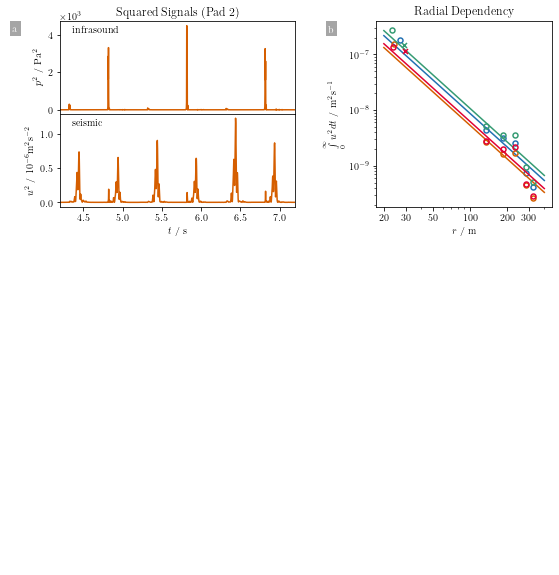

In [125]:
ax = sf2.subplots()
add_char_label('b', ax)
rp = asarray([20, 400])

for pad in (1, 2, 3, 4):
    d = intvsq[f'pad{pad}']
    sta = stations[:-1]
    x = [d['r'][st] for st in sta]
    y = [d['tot'][st] for st in sta]
    # print(sta, y)
    l, = ax.plot(x, y, 'o', color='none', mec=pltt[pad - 1], ms=5, mew=mew)
    lines.append((l,)); labels.append(f'pad {pad}')
    if 'xmb' in d['tot'].keys():
        l, = ax.plot([d['r']['xmb']], [d['tot']['xmb']],
                     'x', ms=5, color=pltt[pad - 1], mew=mew)
        lines[pad - 1] += (l,)
    l, = ax.plot(rp, sq_inverse(rp, bc[f'pad{pad}']), color=pltt[pad - 1])
    lines[pad - 1] += (l,)

ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xticks([20, 30, 50, 100, 200, 300])
ax.set_xticks([40, 60, 70, 80, 90, 400], minor=True)
ax.set_xticklabels([r'$%d$' % tck for tck in ax.get_xticks()])
# ax.legend(loc='upper right')
ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
ax.set_ylabel(r'$\int\limits_0^\infty u^2\,dt\ /\ \mathrm{m^2s^{-1}}$')
ax.set_title('Radial Dependency')
fig

$$
\int_{\Delta t} v^2 dt = \frac{\Delta E - E_\text{a}}{F\,r^2}
= A_\text{I}E_\text{a} + B_\text{I}
$$

$$
\int_0^\infty v^2 dt = \frac{6\Delta E - \sum E_\text{a}}{F\,r^2} = \frac{A_{\text{II}}}{r^2}
$$

In [126]:
def ooxsq(x, a):
    return a / x ** 2

def linear_e(x, dx, a):
    return (dx - x) / a

#### Per Pad at Station \#1

Pad 3 seems different. So, lets fit data to pads 1, 2, 4. Also exclude the `xmb` value of pad 4 blast 6. The air-to ground coupling of that signal looks completely off.

In [127]:
xfa = np.concatenate((
    fit_dr['pad1']['ea'], fit_dr['pad2']['ea'],
    fit_dr['pad4']['ea'], fit_dr['pad4']['ea'][:-1]  # exclude pad 4 blast 6
))
yfa = np.concatenate((
    asarray(fit_dr['pad1']['r'][1] ** 2 * fit_dr['pad1']['intvs'][1]),
    asarray(fit_dr['pad2']['r'][1] ** 2 * fit_dr['pad2']['intvs'][1]),
    asarray(fit_dr['pad4']['r'][1] ** 2 * fit_dr['pad4']['intvs'][1]),
                                                        # exclude pad 4 blast 6
    asarray(fit_dr['pad4']['r']['xmb'] ** 2 * fit_dr['pad4']['intvs']['xmb'][:-1]),
))

In [128]:
fit_dr['pad2']

{'blasts': array([1, 2, 4, 5, 6]),
 'ea': array([  7919.23457089,  32621.26470708,  33367.09170936,   4137.38443352,
         28917.70211361]),
 'dredbar': array([ 0.00395482,  0.00223917,  0.00189186,  0.00395482,  0.00208641]),
 'intvs': {1: array([  2.39111213e-08,   1.84168542e-08,   1.86764997e-08,
           3.72804656e-08,   2.48084593e-08])},
 'r': {1: 24.321774258879273}}

In [129]:
xfa

array([  4315.67563268,   4476.806545  ,   3884.82589146,   1705.38794177,
         2593.53781845,   1848.01916328,   7919.23457089,  32621.26470708,
        33367.09170936,   4137.38443352,  28917.70211361,   8734.29026778,
        23627.87965339,   6401.03061222,  25211.63775446,  11184.16060988,
        28803.01025398,   8734.29026778,  23627.87965339,   6401.03061222,
        25211.63775446,  11184.16060988])

In [130]:
yfa

array([  2.51331612e-05,   2.40867362e-05,   2.38096023e-05,
         2.32882621e-05,   1.69683294e-05,   1.73615405e-05,
         1.41445928e-05,   1.08944662e-05,   1.10480592e-05,
         2.20532111e-05,   1.46754120e-05,   1.13863340e-05,
         9.96247695e-06,   1.53344639e-05,   1.08183309e-05,
         1.38588281e-05,   1.48419353e-05,   1.70611807e-05,
         1.59649386e-05,   2.11481414e-05,   1.74787048e-05,
         1.61519192e-05])

In [131]:
xfa.shape, yfa.shape

((22,), (22,))

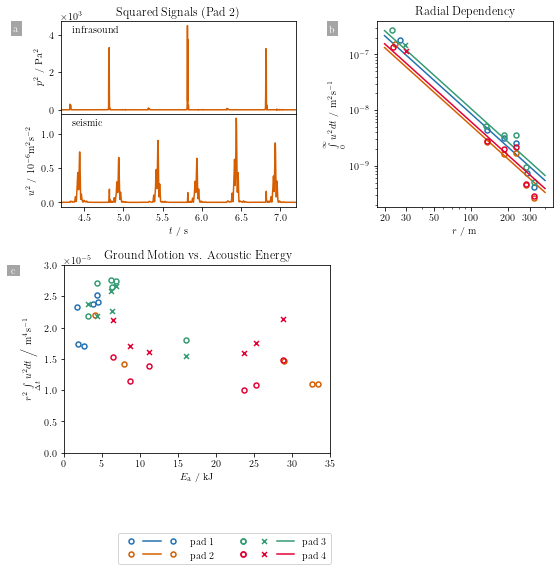

In [132]:
ax = sf3.subplots()
add_char_label('c', ax)

for pad in (1, 2, 3, 4):
    ps = f'pad{pad}'
    d, ea, intvs = intvsq[ps], fit_dr[ps]['ea'], fit_dr[ps]['intvs']
    r = d['r'][1]
    ys = r ** 2 * intvs[1]
    l, = ax.plot(ea / 1e3, ys, 'o', ms=5, color='none', mec=pltt[pad - 1], mew=mew)
    lines[pad - 1] += (l,)
    if 'xmb' in intvs.keys():
        r = d['r']['xmb']
        ys = r ** 2 * intvs['xmb']
        if pad == 4:
            ea_single, y_single = [ea[-1] / 1e3,], [ys[-1],]
            ea, ys = ea[:-1], ys[:-1]
            l_single, = ax.plot(
                ea_single, y_single, 'x', ms=5, mew=mew, color=pltt[pad - 1])
        ax.plot(ea / 1e3, ys, 'x', ms=5, mew=mew, color=pltt[pad - 1])

ax.set_xlabel(r'$E_\text{a}\ /\ \mathrm{kJ}$')
ax.set_ylabel(r'$r^2\,\Bigl.\int\limits_{\Delta t} u^2dt\ \Bigr/\ \mathrm{m^4s^{-1}}$')
ax.set_xlim(0, 35);
ax.set_ylim(0, 3e-5)
ax.set_title('Ground Motion vs. Acoustic Energy')
lines = [tuple(line) for line in lines]
ax.legend(handles=lines, labels=labels, **legopts)
sf3.subplots_adjust(left=.17, right=.98, bottom=.35, top=.92)
sf3.align_ylabels()
fig

In [133]:
res = curve_fit(linear, xfa, yfa)
res

(array([ -2.82751117e-10,   2.06219858e-05]),
 array([[  4.87854248e-21,  -6.76139234e-17],
        [ -6.76139234e-17,   1.52177198e-12]]))

In [134]:
ai_a, bi_a = res[0]
σai_a, σbi_a = np.sqrt(res[1].diagonal())
σai_a / ai_a, σbi_a / bi_a

(-0.2470248904703633, 0.059819710789057005)

In [135]:
xfb = np.concatenate((fit_dr['pad3']['ea'], fit_dr['pad3']['ea']))
yfb = np.concatenate((
    fit_dr['pad3']['r'][1] ** 2 * fit_dr['pad3']['intvs'][1],
    fit_dr['pad3']['r']['xmb'] ** 2 * fit_dr['pad3']['intvs']['xmb']
))

In [136]:
res = curve_fit(linear, xfb, yfb)
res

(array([ -6.19085096e-10,   2.81601022e-05]),
 array([[  4.12810912e-20,  -2.95044709e-16],
        [ -2.95044709e-16,   2.83547678e-12]]))

In [137]:
ai_b, bi_b = res[0]
σai_b, σbi_b = np.sqrt(res[1].diagonal())
σai_b / ai_b, σbi_b / bi_b

(-0.32818991778166101, 0.059796920771496828)

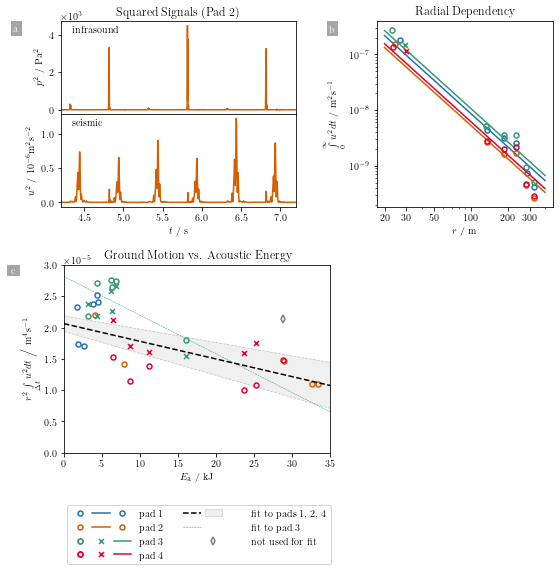

In [138]:
eap = arr([0., 3.5e4])

l, = ax.plot(eap / 1e3, linear(eap, ai_a, bi_a), color='k', ls='dashed')
lines.append((l,)); labels.append('fit to pads 1, 2, 4')
l, = ax.plot(eap / 1e3, linear(eap, ai_b, bi_b),
             color=pltt[2], ls='dashed', lw=.5, label='fit to pad 3', zorder=-1)
lines.append((l,)); labels.append('fit to pad 3')
pc = ax.fill_between(
    eap / 1e3,
    linear(eap, ai_a - σai_a, bi_a - σbi_a),
    linear(eap, ai_a + σai_a, bi_a + σbi_a),
    fc='#f0f0f0', ec='#c5c5c5', lw=.75, ls='dashed', zorder=-2,
)
lines[4] += (pc,); #labels.append(r'$1\sigma\text{ confidence}$')
l_single.set_color('gray')
l_single.set_marker('d')
l_single.set_markerfacecolor('none')
lines.append(l_single); labels.append('not used for fit')
ax.legend(handles=lines, labels=labels, **legopts)
legax = ax
fig

$$
E_\text{s} = -\frac{A_\text{I}}{B_\text{I}} - E_\text{a}
$$

$$
F = \frac{\Delta E - \langle E_\text{a}\rangle}{A_\text{II}}
= -\frac{A_\text{I}/B_\text{I} + \langle E_\text{a}\rangle}{A_\text{II}}
$$

$$
F = -\frac{E_\text{a} + B_\text{I}/A_\text{I}}{r_1^2 \int_{\Delta t} v^2dt}
= - \frac{\langle E_\text{a}\rangle + B_\text{I}/A_\text{I}}{
    r_1^2\ \bigl\langle\int_{\Delta t}v^2 dt\bigr\rangle}
$$

In [139]:
ΔE_a = -bi_a / ai_a
ΔE_b = -bi_b / ai_b
ΔE_a, ΔE_b

(72933.348465328309, 45486.642101350502)

In [140]:
bc

{'pad1': 8.7126368306690029e-05,
 'pad2': 5.3271037457954807e-05,
 'pad3': 0.00010735116458929359,
 'pad4': 6.2401132695558955e-05}

#### Determine proportionality factor $F$

From the per-blast data for each pad:

$$
r^2 \int\limits_{\Delta t} v^2 dt
= \frac{\Delta E - E_\text{a}}{F}
= A_\text{I}E_\text{a} + B_\text{I}
$$

Therefore:

$$
F = \frac{\Delta E - \langle E_\text{a}\rangle}{B_\text{I} + A_\text{I}\langle E_\text{a}\rangle}
$$

In [141]:
fs = {}
for pad in (1, 2, 3, 4):
    fr = fit_dr[f'pad{pad}']
    eamean = fr['ea'].mean()
    if pad == 3:
        de, bi, ai = ΔE_b, bi_b, ai_b
    else:
        de, bi, ai = ΔE_a, bi_a, ai_a
    fs[pad] = (de - eamean) / (bi + ai * eamean)
fs

{1: 3536679215.3943858,
 2: 3536679215.3943863,
 3: 1615286825.7961135,
 4: 3536679215.3943868}

In [142]:
for pad in (1, 2, 3, 4):
    fr = fit_dr[f'pad{pad}']
    print(fr['r'][1] ** 2 * fs[pad] * fr['intvs'][1] / 1e3)
    try:
        print(fr['r']['xmb'] ** 2 * fs[pad] * fr['intvs']['xmb'] / 1e3)
    except: pass

[ 88.88792888  85.18705932  84.20692572  82.36311247  60.01153781
  61.40219958]
[ 50.02488732  38.53023222  39.07344123  77.99513319  51.90222443]
[ 44.58063075  42.83793514  29.17125515  35.26566246  44.31082697
  43.8641784 ]
[ 41.62268903  36.63348064  25.06654447  38.38009266  42.95656058
  35.383306  ]
[ 40.26981086  35.23408515  54.23307958  38.26096599  49.01422915
  52.49116418]
[ 60.33992327  56.46286652  74.79419201  61.81657184  57.12415695
  75.55165931]


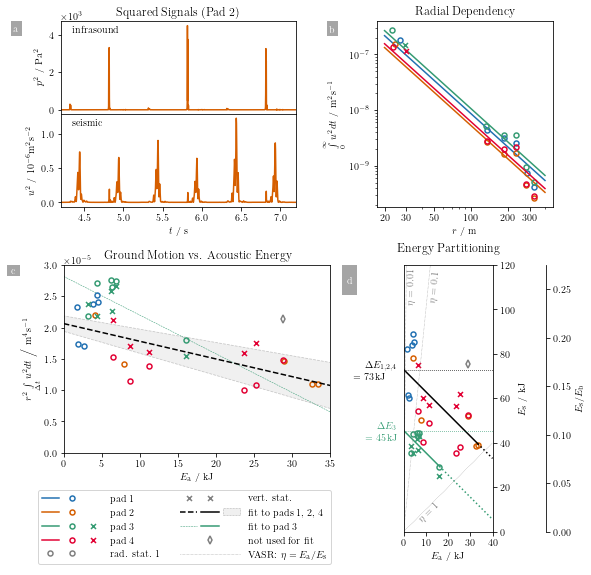

In [143]:
ax = sf4.subplots()

## The 'd' label. add_chadd_char_label does not work here for some reason...
dpi = 100.
pnts = ax.transAxes.transform([(0, 0), (1, 1)])
sfx = dpi / (72 * (pnts[1, 0] - pnts[0, 0]))
sfy = dpi / (72 * (pnts[1, 1] - pnts[0, 1]))
ax.add_artist(plt.Rectangle(
    (-100 * sfx, 1. - 15 * sfy), 25 * sfx, 15 * sfy,
    transform=ax.transAxes, ec='none', fc='#a5a5a5', clip_on=False
))
ax.text(-87.5 * sfx, 1 - 8 * sfy, 'd', ha='center', va='center',
        transform=ax.transAxes, color='white')

eap = arr([0., 4e4])
ax.set_aspect(1)
opts = dict(color='gray', va='top', ha='center', rotation_mode='anchor')

for pad in (1, 2, 3, 4):
    fr = fit_dr[f'pad{pad}']
    ax.plot(fr['ea'] / 1e3, fr['r'][1] ** 2 * fs[pad] * fr['intvs'][1] / 1e3,
            'o', ms=5, color='none', mec=pltt[pad - 1], mew=mew)
    if pad == 3:
        ax.plot(fr['ea'] / 1e3,
                fr['r']['xmb'] ** 2 * fs[pad] * fr['intvs']['xmb'] / 1e3,
                'x', ms=5, color='none', mec=pltt[pad - 1], mew=mew)
    if pad == 4:
        ax.plot(fr['ea'][:-1] / 1e3,
                fr['r']['xmb'] ** 2 * fs[pad] * fr['intvs']['xmb'][:-1] / 1e3,
                'x', ms=5, color='none', mec=pltt[pad - 1], mew=mew)
        ax.plot([fr['ea'][-1] / 1e3,],
                [fr['r']['xmb'] ** 2 * fs[pad] * fr['intvs']['xmb'][-1] / 1e3],
                'd', ms=5, color='none', mec='gray', mew=mew)
## ΔE lines
ea = arr([0, fit_dr['pad2']['ea'].max()])
l, = ax.plot(ea / 1e3, (ΔE_a - ea) / 1e3, '-k')
lines[4] += (l, )
ea = arr([fit_dr['pad2']['ea'].max(), 40e3]);
ax.plot(ea / 1e3, (ΔE_a - ea) / 1e3, color='k', ls='dotted')
ea = arr([0, fit_dr['pad3']['ea'].max()])
l, = ax.plot(ea / 1e3, (ΔE_b - ea) / 1e3, '-', color=pltt[2])
lines[5] += (l,)
ea = arr([fit_dr['pad3']['ea'].max(), 40e3])
ax.plot(ea / 1e3, (ΔE_b - ea) / 1e3, ls='dotted', color=pltt[2])
ax.axhline(ΔE_a / 1e3, color='k', lw=.75, ls='dotted')
ax.axhline(ΔE_b / 1e3, color=pltt[2], lw=.75, ls='dotted')
## ΔE labels
ax.text(-3, ΔE_b / 1e3, r'$\Delta E_\text{3}\\{\ =%.0f\,\mathrm{kJ}}$' % (ΔE_b / 1e3),
        ha='right', va='center', color=pltt[2])
ax.text(-3, ΔE_a / 1e3, r'$\Delta E_\text{1,2,4}\\{\ =%.0f\,\mathrm{kJ}}$' % (ΔE_a / 1e3),
        ha='right', va='center', color='k')

## the VASR lines
ax.plot([0, 40], [0, 40], color='gray', ls='dotted', lw=.5)
l, = legax.plot([], [], color='gray', ls='dotted', lw=.5)
ax.text(10, 10, r"$\eta=1$", rotation=180 * np.arctan(1) / np.pi, **opts)
ax.plot([0, 15], [0, 150], color='gray', ls='dotted', lw=.5)
ax.text(12, 110, r"$\eta=0.1$", rotation=180 * np.arctan(10) / np.pi, **opts)
ax.plot([0, 1.5], [0, 150], color='gray', ls='dotted', lw=.5)
ax.text(1.5, 110, r"$\eta=0.01$", rotation=180 * np.arctan(100) / np.pi, **opts)
lines.append(l); labels.append(r'VASR: $\eta=E_\text{a}/E_\text{s}$')

ax.set_xlabel(r'$E_\text{a}\ /\ \mathrm{kJ}$')
ax.set_ylabel(r'$E_\text{s}\ /\ \mathrm{kJ}$')
ax.set_xlim(0, 40); ax.set_ylim(0, 120)
ax.set_xticks([0, 10, 20, 30, 40])
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax2 = ax.secondary_yaxis(
    1.6, functions=(lambda x: x * 1e3 / EBLAST, lambda y: y * EBLAST / 1e3))
ax2.set_ylabel(r'$E_\text{s}/E_\text{b}$')
ax.set_title(r'Energy Partitioning', y=1.025)
# re-order legend patches
handles = []
el = lines[0]
handles.append((el[1], el[0]))
el = lines[1]
handles.append((el[1], el[0]))
el = lines[2]
handles.append((el[2], el[0], el[1]))
el = lines[3]
handles.append((el[2], el[0], el[1]))
l, = legax.plot([], [], 'o', color='none', mec='gray', mew=mew, ms=5)
handles.append((l, l)); labels.insert(4, 'rad. stat. 1')
l, = legax.plot([], [], 'x', color='none', mec='gray', mew=mew, ms=5)
handles.append((l, l)); labels.insert(5, 'vert. stat.')
el = lines[4]
handles.append((el[0], el[2], el[1]))
for el in lines[5:]:
    handles.append(el)
legax.legend(handles=handles, labels=labels, **legopts)
sf4.subplots_adjust(left=0, right=.9, bottom=.11)
fig

In [144]:
plt.rc('font', size=15)

In [145]:
fitdx = np.concatenate([fit_dr[f'pad{pad}']['dredbar'] for pad in (1, 2, 4)])
fitdy = np.concatenate([fit_dr[f'pad{pad}']['ea'] for pad in (1, 2, 4)])
fitdy

array([  4315.67563268,   4476.806545  ,   3884.82589146,   1705.38794177,
         2593.53781845,   1848.01916328,   7919.23457089,  32621.26470708,
        33367.09170936,   4137.38443352,  28917.70211361,   8734.29026778,
        23627.87965339,   6401.03061222,  25211.63775446,  11184.16060988,
        28803.01025398])

In [146]:
res = curve_fit(linear, fitdx, np.log(fitdy))
res

(array([-1038.80994894,    12.71739755]),
 array([[  8.95349674e+03,  -3.15911344e+01],
        [ -3.15911344e+01,   1.19006485e-01]]))

In [147]:
dbar4 = -1. / res[0][0]
dbar4

0.00096263999110085053

In [148]:
ear0 = np.e ** res[0][1] / EBLAST
ear0

0.76403162186167339

[ 0.00395482  0.00395482  0.00395482  0.00482697  0.0044256   0.00482788]
[ 0.00395482  0.00223917  0.00189186  0.00395482  0.00208641]
[ 0.00395482  0.00260486  0.00395482  0.00248968  0.00395482  0.0029511 ]


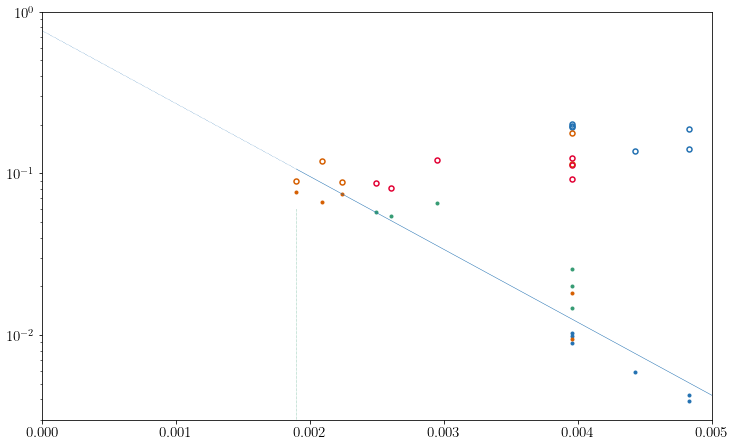

In [149]:
fig, ax = plt.subplots()

for pad in (1, 2, 4):
    ps = f'pad{pad}'
    el = fit_dr[ps]
    print(el['dredbar'])
    ax.plot(el['dredbar'], el['ea'] / EBLAST, '.')
    ax.plot(el['dredbar'], el['r'][1] ** 2 * fs[pad] * el['intvs'][1] / EBLAST,
            'o', ms=5, color='none', mec=pltt[pad - 1], mew=mew)
xp = arr([0, 1.9e-3])
ax.plot(xp, ear0 * np.exp(-xp / dbar4), ls='dotted', lw=.5, color=pltt[0])
ax.plot(xp, ΔE_a / EBLAST - ear0 * np.exp(-xp / dbar4), ls='dotted', lw=.5, color=pltt[2])
xp = arr([1.9e-3, 5e-3])
ax.plot(xp, ear0 * np.exp(-xp / dbar4), ls='solid', lw=.5, color=pltt[0])

ax.set_xlim(0, 5e-3)
ax.set_ylim(3e-3, 1)
ax.set_yscale('log')